In [ ]:
#default_exp core.vase_model

In [ ]:
#export
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from cmaes import CMA
import os
import numpy as np
import copy

from cult.core.models import FCEncoder, FCDecoder, Encoder, Decoder, EnvironmentInference
from cult.core.utils import rec_likelihood, disable_gradient, kl_div_stdnorm, euclidean, show_batch
from cult.config import DATA_PATH, LOG_PATH

In [ ]:
#hide
from cult.core.datasets.moving_mnist import CommonMNIST, CommonFashionMNIST, MovingMNIST, MovingFashionMNIST, FixedMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
batch_size = 64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
small_fashion = CommonFashionMNIST(DATA_PATH, transform=ToTensor())
sf_loader = DataLoader(small_fashion, batch_size=batch_size, shuffle=True)
sf_batch, _ = iter(sf_loader).next()
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, batch_size, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()
mm_data = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
mm_loader = DataLoader(mm_data, batch_size, shuffle=True)
mm_batch, _, _ = iter(mm_loader).next()

# Vase Model

New algorithm for environment detection - if kl div exceeds threshold, allocate new environment - don't allocate another new environment until kl div falls below threshold

In [ ]:
#export
class VASE(nn.Module):
    def __init__(self, 
        encoder_type: type,
        decoder_type: type,
        latents: int,
        final_size: int,
        max_envs: int,
        env_optim: type, 
        env_lr: float,
        replay_batch_size: int,
        tau: int,
        kappa: float,  
        lam: float,
        lam_1: float,
        lam_2: float, 
        Tau: float,
        used_epochs: int,
        used_delta: float,
        used_sigma: float,
        device: str
    ):
        super().__init__()
        self.latents = latents
        self.max_envs = max_envs
        self.final_size = final_size
        self.device = device
        self.encoder = encoder_type(self.latents, device=self.device)
        self.decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.old_encoder = encoder_type(self.latents, device=self.device)
        self.old_decoder = decoder_type(self.latents, self.max_envs, device=self.device)
        self.copy_and_freeze()
        self.encoder.to(self.device), self.decoder.to(self.device), self.old_encoder.to(self.device), self.old_decoder.to(self.device)
        self.steps = 0
        self.tau = tau
        self.replay_batch_size = replay_batch_size
        self.env_net = EnvironmentInference(self.max_envs, self.final_size)
        self.env_net.to(self.device)
        self.m = 0
        self.env_optim = env_optim(params=self.env_net.parameters(), lr=env_lr)
        self.env_loss = nn.CrossEntropyLoss()
        self.rec_losses = []
        self.kappa = kappa
        self.masks = []
        self.lam = lam
        self.lam_1 = lam_1
        self.lam_2 = lam_2
        self.Tau = Tau
        self.used_epochs = used_epochs
        self.used_delta = used_delta
        self.used_sigma = used_sigma

    def forward(self, x):
        batch_size = x.shape[0]
        self.steps += 1

        mu, logvar, final = self.encoder(x)
        s_hat, env_logits = self.get_likely_env(final)
        if self.training:
            z = self.reparam(mu, logvar)
        else:
            z = mu
        
        a, alphas = self.get_mask(z)
        masked_z, masked_mu, masked_logvar = self.apply_mask(z, a, mu, logvar)

        s = self.infer_env(x, batch_size, masked_z, s_hat, a, z)
        
        rec_x = self.decoder(masked_z, self.int_to_vec(s, batch_size))
        
        if not self.training:
            return rec_x
        
        x_halu, s_halu = self.sample_old()
        with torch.no_grad():
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            z_halu_old = self.reparam(mu_halu_old, logvar_halu_old)
            a_halu_old = torch.stack([self.masks[s] for s in s_halu.tolist()])
            masked_z_halu_old, masked_mu_halu_old, masked_logvar_halu_old = self.apply_mask(z_halu_old, a_halu_old, mu_halu_old, logvar_halu_old)
        
        mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
        z_halu = self.reparam(mu_halu, logvar_halu)
        a_halu, alphas_halu = self.get_mask(z_halu)
        masked_z_halu, masked_mu_halu, masked_logvar_halu = self.apply_mask(z_halu, a_halu, mu_halu, logvar_halu)
        rec_x_halo = self.decoder(masked_z_halu, s_halu)

        self.train_env_network(env_logits, s, final_halu_old, s_halu)

        if self.tau and self.steps > self.tau:
            self.copy_and_freeze()

        return rec_x, masked_mu, masked_logvar, x_halu, masked_z_halu_old, rec_x_halo, masked_z_halu, alphas

    def get_mask(self, z):
        std, mean = torch.std_mean(z, dim=0)
        std = std[:,None]
        mean = mean[:, None]
        logvar = torch.log(std.pow(2))
        alphas = kl_div_stdnorm(mean, logvar)
        # alphas[alphas < self.lam_1] = 0
        # alphas[alphas > self.lam_2] = 1
        a = alphas < self.lam
        a[alphas > self.lam_2] = 1
        return a, alphas
    
    def get_likely_env(self, final):
        env_logits = self.env_net(final)
        avg_env_logits = torch.mean(env_logits, dim=0)
        valid_logits = avg_env_logits[0:self.m+1]
        return torch.argmax(valid_logits), env_logits
    
    def reparam(self, mu, logvar):
        eps = torch.randn(logvar.shape).to(self.device)
        std = (0.5 * logvar).exp()
        return mu + std * eps
    
    def infer_env(self, x, batch_size, masked_z, s_hat, a, z):
        with torch.no_grad():
            rec_x = self.decoder(masked_z, self.int_to_vec(s_hat, batch_size))
        rec_loss = torch.mean(rec_likelihood(x, rec_x))
        
        if len(self.rec_losses) == 0:
            self.init_env(rec_loss, a)
            return 0
        
        if self.m == self.max_envs - 1:
            self.update_env(rec_loss, a, self.m)
            return self.m
        
        if rec_loss > self.kappa * self.rec_losses[s_hat]:
            self.m+=1
            self.init_env(rec_loss, a)
            return self.m
        
        if not torch.equal(a, self.masks[s_hat]):
            u = self.get_used_mask(x, batch_size, z, s_hat)
            if not torch.equal(a * u, self.masks[s_hat] * u):
              self.m+=1
              self.init_env(rec_loss, a)
              return self.m

        self.update_env(rec_loss, a, s_hat)
        return s_hat 
        
    def init_env(self, rec_loss, a):
        if self.tau is None:
            self.copy_and_freeze()
        self.rec_losses.append(rec_loss)
        self.masks.append(a)
    
    def update_env(self, rec_loss, a, s):
        self.rec_losses[s] = rec_loss
        self.masks[s] = a
    
    def get_used_mask(self, x, batch_size, z, s_hat):
        x = copy.copy(x).to('cpu')
        z = copy.copy(z).to('cpu')
        s_hat = copy.copy(s_hat).to('cpu')
        optimizer = CMA(mean=np.zeros(self.latents), sigma=self.used_sigma)
        s_vec = self.int_to_vec(s_hat, batch_size)
        for generation in range(self.used_epochs):
            solutions = []
            for _ in range(optimizer.population_size):
                sigma_a = optimizer.ask()
                with torch.no_grad():
                    sigma_t = torch.tensor(sigma_a, dtype=torch.float)
                    sigma_t = torch.abs(sigma_t)
                    eps = torch.randn(sigma_t.shape[0]) * sigma_t
                    z_e = (1-self.used_delta) * z + (self.used_delta + eps)
                    rec_x = self.decoder(z_e, s_vec)
                    rec_loss = torch.mean(rec_likelihood(x, rec_x))
                    sum_sigma = torch.sum(sigma_t)
                    loss = rec_loss - sum_sigma
                value = loss.detach().numpy()
                solutions.append((sigma_a, value))
            optimizer.tell(solutions)
        sigma_p_a = sorted(solutions, key=lambda pair: pair[1], reverse=True)[0][0]
        sigma_p_t = torch.tensor(sigma_p_a, dtype=torch.float).abs()
        u = sigma_p_t < self.Tau
        u = u.to(self.device)
        return sigma_p_t < self.Tau

    
    def int_to_vec(self, i, size):
        return torch.ones([size], dtype=torch.int64).to(self.device) * i
    
    def apply_mask(self, z, a, mu, logvar):
        #TODO: verify it broadcasts correctly in both cases
        std_norm = torch.randn(z.shape).to(self.device)
        masked_z = a * z + (~a) * std_norm # "reparam" trick again
        masked_mu = mu * a
        masked_logvar = logvar * a
        return masked_z, masked_mu, masked_logvar
    
    def copy_model(self, old_model, cur_model):
        old_model.load_state_dict(cur_model.state_dict())
    
    def freeze_model(self, model):
        disable_gradient(model)
    
    def copy_and_freeze(self):
        self.copy_model(self.old_encoder, self.encoder)
        self.freeze_model(self.old_encoder)
        self.copy_model(self.old_decoder, self.decoder)
        self.freeze_model(self.old_decoder)
    
    def train_env_network(self, env_logits, s, final_halu_old, s_halu):
        final_halu_old = final_halu_old[s != s_halu]
        s_halu = s_halu[s != s_halu]
        self.env_optim.zero_grad()
        cur_loss = self.env_loss(env_logits, self.int_to_vec(s, env_logits.shape[0])) #don't know if dims work here
        if len(s_halu) > 0:
            env_logits_halu = self.env_net(final_halu_old)
            replay_loss = self.env_loss(env_logits_halu, s_halu)
        else: 
            replay_loss = 0
        loss = cur_loss + replay_loss
        loss.backward(retain_graph=True)
        self.env_optim.step()
    
    def sample_old(self):
        s = torch.randint(0, self.m+1, (self.replay_batch_size,)).to(self.device)
        z = torch.randn([self.replay_batch_size, self.latents]).to(self.device)
        with torch.no_grad():
            halu_x = self.old_decoder(z, s)
        return halu_x, s

In [ ]:
def train(vase_model, loader, epochs, C, alpha, beta, optimizer, writer):
    for epoch in range(epochs):
        total_loss = 0
        total_rec_loss = 0
        total_div_loss = 0
        for contents in loader:
            X = contents[0]
            X = X.to(device)
            optimizer.zero_grad()

            rec_x, masked_mu, masked_logvar, x_halu, masked_z_halu_old, rec_x_halo, masked_z_halu, alphas = vase_model(X)

            rec_loss = torch.mean(rec_likelihood(X, rec_x))
            kl_loss = gamma * torch.mean(torch.square(kl_div_stdnorm(masked_mu, masked_logvar)-C)) #NOTE: is this element wise or summed
            mdl_loss = rec_loss + kl_loss

            e_prox_loss = alpha * torch.mean(euclidean(masked_z_halu, masked_z_halu_old))
            d_prox_loss = beta * torch.mean(rec_likelihood(x_halu, rec_x_halo)) #NOTE: not sure if this order is correct
            dream_loss = e_prox_loss + d_prox_loss

            loss = mdl_loss + dream_loss

            loss.backward(retain_graph=True)
            optimizer.step()

            writer.add_scalar("train/loss", loss, vase_model.steps)
            writer.add_scalar("train/rec_loss", rec_loss, vase_model.steps)
            writer.add_scalar("train/kl_loss", kl_loss, vase_model.steps)
            writer.add_scalar("train/e_prox_loss", e_prox_loss, vase_model.steps)
            writer.add_scalar("train/d_prox_loss", d_prox_loss, vase_model.steps)
            writer.add_scalar("train/num_envs", vase_model.m+1, vase_model.steps)
            writer.add_scalar("train/atypicality", alphas.mean(), vase_model.steps)
            # if alphas.mean() > .25:
            #     print("atypical alphas")
            total_loss += loss
            total_rec_loss += rec_loss
            total_div_loss += kl_loss
        print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")
    

In [ ]:
latents=24
final_size=50
max_envs=7
env_optim=torch.optim.Adam
env_lr=6e-4
replay_batch_size=64
tau=None
kappa=1.5
lam=5
lam_1=0.01
lam_2=10
Tau=.1
used_epochs=100
used_delta=.95
used_sigma = 1.3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vase_fc = VASE(FCEncoder, FCDecoder, latents, final_size, max_envs, env_optim, env_lr, replay_batch_size, tau, kappa, lam, lam_1, lam_2, Tau, used_epochs, used_delta, used_sigma, device)

epochs=10
lr=6e-4
gamma=4
C=0
alpha=1
beta=10
optimizer = torch.optim.Adam(params=vase_fc.parameters(), lr=lr)
name = "vase" + dt.datetime.now().strftime('-%Y-%m-%d-%H-%M-%S')
writer = SummaryWriter(os.path.join(LOG_PATH, name))

In [ ]:
train(vase_fc, sf_loader, epochs, C, alpha, beta, optimizer, writer)

epoch: 0, loss=84934.703125, rec_loss=5376.9560546875, total_div_loss=142.13682556152344
epoch: 1, loss=84221.8984375, rec_loss=4665.3330078125, total_div_loss=216.02682495117188
epoch: 2, loss=84036.4765625, rec_loss=4499.25390625, total_div_loss=238.99586486816406
epoch: 3, loss=83883.3046875, rec_loss=4381.11328125, total_div_loss=257.6081237792969
epoch: 4, loss=83824.8671875, rec_loss=4333.1005859375, total_div_loss=271.2164001464844


KeyboardInterrupt: 

In [ ]:
train(vase_fc, mnist_loader, epochs, C, alpha, beta, optimizer, writer)

epoch: 0, loss=37026.13671875, rec_loss=2977.49853515625, total_div_loss=94.65823364257812
epoch: 1, loss=32703.673828125, rec_loss=2841.813232421875, total_div_loss=81.79813385009766
epoch: 2, loss=32084.88671875, rec_loss=2823.971435546875, total_div_loss=80.01466369628906
epoch: 3, loss=31925.22265625, rec_loss=2814.265380859375, total_div_loss=79.49152374267578
epoch: 4, loss=31830.759765625, rec_loss=2807.87939453125, total_div_loss=80.09193420410156
epoch: 5, loss=31657.69921875, rec_loss=2799.919189453125, total_div_loss=81.32325744628906
epoch: 6, loss=31618.072265625, rec_loss=2793.130859375, total_div_loss=83.46701049804688
epoch: 7, loss=31548.068359375, rec_loss=2787.259033203125, total_div_loss=85.00896453857422
epoch: 8, loss=31406.98828125, rec_loss=2781.923095703125, total_div_loss=86.64995574951172
epoch: 9, loss=31362.22265625, rec_loss=2777.453369140625, total_div_loss=88.28363037109375


In [ ]:
latents=24
final_size=256
max_envs=7
env_optim=torch.optim.Adam
env_lr=6e-4
replay_batch_size=64
tau=2500
kappa=1.5
lam=.75
lam_1=0.01
lam_2=10
Tau=.1
used_epochs=100
used_delta=.95
used_sigma = 1.3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vase_cnn = VASE(Encoder, Decoder, latents, final_size, max_envs, env_optim, env_lr, replay_batch_size, tau, kappa, lam, lam_1, lam_2, Tau, used_epochs, used_delta, used_sigma, device)

epochs=10
lr=6e-4
gamma=4
C=0
alpha=1
beta=10
optimizer = torch.optim.Adam(params=vase_cnn.parameters(), lr=lr)
name = "vase" + dt.datetime.now().strftime('-%Y-%m-%d-%H-%M-%S')
writer = SummaryWriter(os.path.join(LOG_PATH, name))

In [ ]:
train(vase_cnn, fashion_loader, epochs, C, alpha, beta, optimizer, writer)

In [ ]:
train(vase_cnn, mm_loader, epochs, C, alpha, beta, optimizer, writer)

TODO: calibrate lamda - there is a spike in atypicality with mnist, but for some reasons we're not picking it up 

the problem is that if we pick up on it on mnist, it screws up the training on fashionmnist - we could just assign a new environment every time it goes over the anomoly, but that screws up the masking.

Next course of action is just try on the bigger dataset on collab

also create training function.

Good Job! You're getting really good results!!!!

In [ ]:
vase_fc.eval()

VASE(
  (encoder): FCEncoder(
    (linear1): Linear(in_features=784, out_features=50, bias=True)
    (linear_mu): Linear(in_features=50, out_features=24, bias=True)
    (linear_logvar): Linear(in_features=50, out_features=24, bias=True)
    (act): ReLU()
  )
  (decoder): FCDecoder(
    (linear1): Linear(in_features=31, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (old_encoder): FCEncoder(
    (linear1): Linear(in_features=784, out_features=50, bias=True)
    (linear_mu): Linear(in_features=50, out_features=24, bias=True)
    (linear_logvar): Linear(in_features=50, out_features=24, bias=True)
    (act): ReLU()
  )
  (old_decoder): FCDecoder(
    (linear1): Linear(in_features=31, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (env_net): EnvironmentInference(
    (linear): Linear(in_features=50

In [ ]:
with torch.no_grad():
    rec_batch = vase_fc(sf_batch)

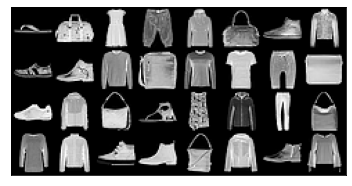

In [ ]:
show_batch(sf_batch[0:32])

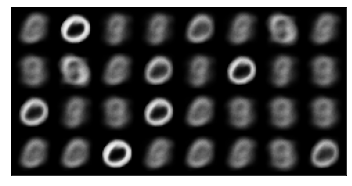

In [ ]:
show_batch(rec_batch[0:32])